In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import glob
import os

In [63]:
models = ['FF', 'LSTM', 'Att1', 'Att2', 'Att3', ]
model_names = ['Feed Forward', 'LSTM', 'Attention for Obs', 'Attention for Obs+Action', 'Attention+Action-', ]

In [2]:
res_groups = {}
for model in models:
    print(model)
    path_res = f'res/{model}_hs_5_l1_3_l2_3_TrueTrue3000000'
    model_list = []
    for file in sorted(glob.glob(os.path.join(path_res, "*.pkl"))):
         with open(file, "rb") as f:
                model_list.append(pickle.load(f))
    res_groups[model] = model_list

FF
LSTM
Att1
Att2
Att3


In [6]:
xp_groups = {}

for model in models:
    print(model)
    path_res = f'sample/same_hand/xp_{model}_same.csv'
    xp_groups[model] = pd.read_csv(path_res, index_col=0)

FF
LSTM
Att1
Att2
Att3


## Part 1: Learning curves

In [7]:
def plot_avg(res_list, label):
    moving_avgs = []
    for res in res_list:
        rewards = res['rewards']
        rewards = np.array(rewards)
        rewards = rewards.reshape(500,-1)
        moving_avg = np.mean(rewards, axis=1)
        moving_avgs.append(moving_avg)
    moving_avgs = np.array(moving_avgs)
    moving_avg_avg = np.mean(moving_avgs, axis=0)
    plt.plot(moving_avg_avg, label=label)

## Part 2: Self-play scores

SP score for each model. The mean and std are for differently-seeded agents. Each agent pair plays 100 games for sample.

In [30]:
for model in models:
    meanscore = np.diag(xp_groups[model]).mean()
    stdscore = np.diag(xp_groups[model]).std()
    print('{:.2}'.format(meanscore), '{:.2}'.format(stdscore), model, 'SP')

0.9 0.034 FF SP
0.86 0.037 LSTM SP
0.92 0.034 Att1 SP
0.82 0.084 Att2 SP
0.9 0.13 Att3 SP


### Sample a few games for each architecture

In models except Att3, the conventions are not dicipherable. Which card to hint/play not only depend on the label on the relavent cards, but also seem to intricately depends on other cards in the hand as well.

In Att3, they just hint the playable card one cluster, and the furtherest card in the other cluster.

In [31]:
from sample.sample import sample_games

game_num = 2

In [32]:
model = 'FF'

p1 = res_groups[model][0]['p1']
p2 = res_groups[model][0]['p2']

sample_games(p1, p2, episodes=game_num, verbose=True)

===== Game starts with handsize: 5, nlabl: 3, nlab2: 3 =====
Playable hand is: 3A
Agent 1 hand is: ['2C', '2B', '2C', '3̲A', '1C']
Agent 2 hand is: ['2C', '2C', '3̲A', '2B', '1C']
Agent 1 hints 3A @  3
Agent 2 plays 3A @  2
Final reward of game: 1.0


===== Game starts with handsize: 5, nlabl: 3, nlab2: 3 =====
Playable hand is: 3B
Agent 1 hand is: ['3̲B', '1B', '2B', '3A', '1A']
Agent 2 hand is: ['2B', '1A', '3A', '1B', '3̲B']
Agent 1 hints 2B @  2
Agent 2 plays 3B @  4
Final reward of game: 1.0




array([1., 1.], dtype=float32)

In [36]:
model = 'Att3'

p1 = res_groups[model][0]['p1']
p2 = res_groups[model][0]['p2']

sample_games(p1, p2, episodes=game_num, verbose=True)

===== Game starts with handsize: 5, nlabl: 3, nlab2: 3 =====
Playable hand is: 2C
Agent 1 hand is: ['1B', '3C', '2A', '1A', '2̲C']
Agent 2 hand is: ['1B', '1A', '2A', '2̲C', '3C']
Agent 1 hints 2C @  4
Agent 2 plays 2C @  3
Final reward of game: 1.0


===== Game starts with handsize: 5, nlabl: 3, nlab2: 3 =====
Playable hand is: 2A
Agent 1 hand is: ['2̲A', '2C', '1C', '3A', '2̲A']
Agent 2 hand is: ['1C', '2̲A', '2C', '2̲A', '3A']
Agent 1 hints 2A @  0
Agent 2 plays 2A @  3
Final reward of game: 1.0




array([1., 1.], dtype=float32)

In [37]:
model = 'Att3'

p1 = res_groups[model][2]['p1']
p2 = res_groups[model][2]['p2']

sample_games(p1, p2, episodes=game_num, verbose=True)

===== Game starts with handsize: 5, nlabl: 3, nlab2: 3 =====
Playable hand is: 1B
Agent 1 hand is: ['3A', '1C', '1̲B', '3C', '1̲B']
Agent 2 hand is: ['1̲B', '1̲B', '3A', '3C', '1C']
Agent 1 hints 3C @  3
Agent 2 plays 1B @  1
Final reward of game: 1.0


===== Game starts with handsize: 5, nlabl: 3, nlab2: 3 =====
Playable hand is: 3C
Agent 1 hand is: ['3A', '3A', '2B', '3A', '3̲C']
Agent 2 hand is: ['3A', '2B', '3̲C', '3A', '3A']
Agent 1 hints 3A @  1
Agent 2 plays 2B @  1
Final reward of game: 0.0




array([1., 0.], dtype=float32)

## XP matrices

In [53]:
def arg_sort_xp(xpm):
    xpm = xpm.values
    idx = np.argsort(xpm[:,0])
    xpm = xpm[idx][:,idx]
    return xpm

ff = arg_sort_xp(xp_groups['FF'])
lstm = arg_sort_xp(xp_groups['LSTM'])
att1 = arg_sort_xp(xp_groups['Att1'])
att2 = arg_sort_xp(xp_groups['Att2'])
att3 = arg_sort_xp(xp_groups['Att3'])

In [69]:
def get_table_scores(mat):
    sp_score_mean, sp_score_std = np.mean(np.diag(mat)), np.sqrt(np.var(np.diag(mat)))
    off_diag = np.where(~np.eye(mat.shape[0],dtype=bool))
    xp_score_mean, xp_score_std = np.mean(mat[off_diag]), np.sqrt(np.var(mat[off_diag]))
    return sp_score_mean, sp_score_std, xp_score_mean, xp_score_std

clus =8  

print("Feed forward: ")
print(get_table_scores(ff))
print("Att3: ")
print(get_table_scores(att3))
print("Att3 cluster 1: ")
print(get_table_scores(att3[:clus,:clus]))
print("Att3 cluster 2: ")
print(get_table_scores(att3[clus:,clus:]))

Feed forward: 
(0.8978666623433431, 0.03371620313471019, 0.28765714328203884, 0.11413490906803639)
Att3: 
(0.8965714261645362, 0.1334625249189683, 0.47137142899113577, 0.4701025473673431)
Att3 cluster 1: 
(0.7284999936819077, 0.03355219230034552, 0.7329285740852356, 0.028814592717858297)
Att3 cluster 2: 
(1.0, 0.0, 1.0, 0.0)


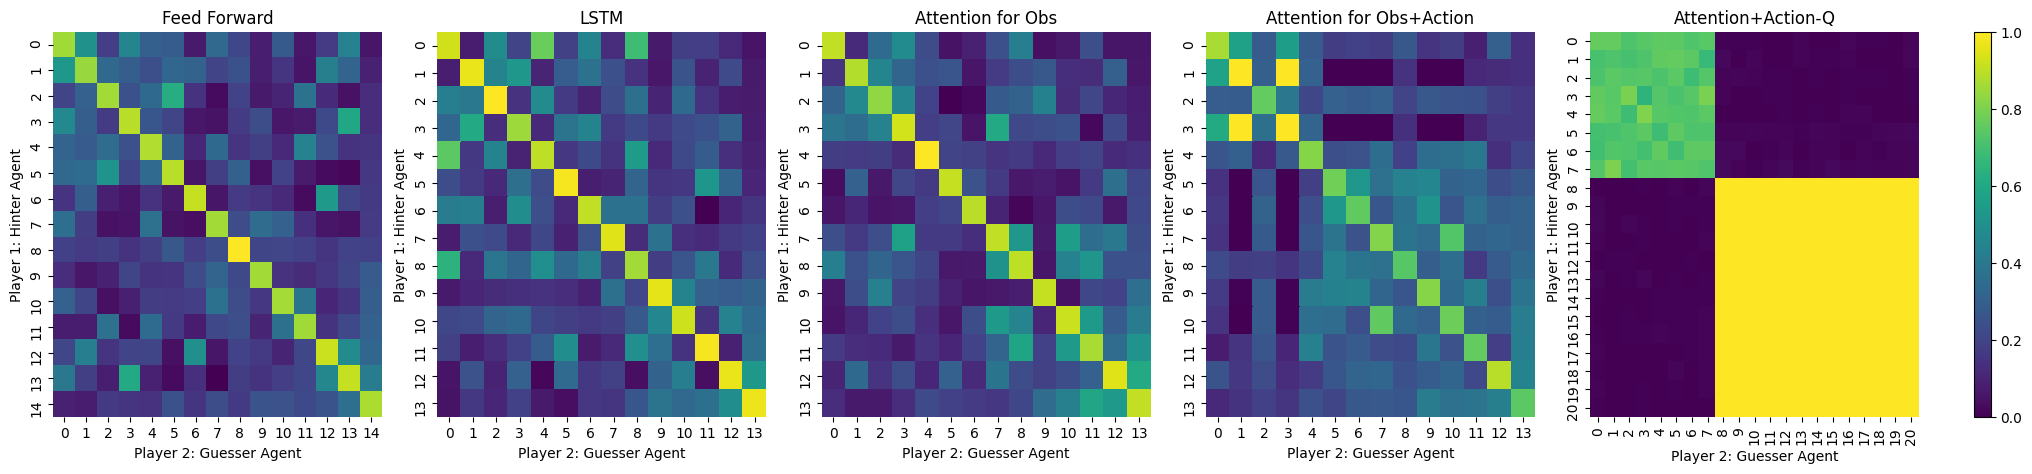

In [71]:
fig, axs = plt.subplots(ncols=6, gridspec_kw=dict(width_ratios=[4,4,4,4,4,0.2]), figsize=(25,5))

cmap = "viridis"
# cmap = "rocket"


sns.heatmap(ff, cbar=False, ax=axs[0], cmap=cmap)
sns.heatmap(lstm, cbar=False, ax=axs[1], cmap=cmap)
sns.heatmap(att1, cbar=False, ax=axs[2], cmap=cmap)
sns.heatmap(att2, cbar=False, ax=axs[3], cmap=cmap)
sns.heatmap(att3, cbar=False, ax=axs[4], cmap=cmap)

fig.colorbar(axs[3].collections[0], cax=axs[5])

for i in range(5):
    axs[i].set_ylabel('Player 1: Hinter Agent')
    axs[i].set_xlabel('Player 2: Guesser Agent')
    axs[i].title.set_text(model_names[i])

plt.show()